In [1]:
# 📦 Стандартные библиотеки
import os
import json
import time
import random
import glob
from pathlib import Path

# 📊 Обработка и визуализация данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 🤖 Машинное обучение (sklearn)
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 🔥 PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# ⏳ Прогресс-бар
from tqdm import tqdm

In [2]:
# ----------------------------
# Device setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🛠 Device: {device}")

# ----------------------------
# Paths setup (UNIX style)
# ----------------------------

# 🔧 Вставь сюда свои актуальные пути:
# DATA_ROOT = Path("/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/cnn_input")
DATA_ROOT = Path("/kaggle/input")
# SAVE_ROOT = Path("/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f")
SAVE_ROOT = Path("/kaggle/working/")
# CONFIG_PATH = Path("/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f/cnn_2e-04lr_64bs_ELU_16f.json")
CONFIG_PATH = Path("/kaggle/input/cnn_2e-04lr_64bs_ELU_16f.json")
LOG_CSV_PATH = SAVE_ROOT / "stability_log.csv"

# ----------------------------
# Function to create a run-specific directory
# ----------------------------
def create_run_directory(
    run_name="cnn", lr=1e-3, batch_size=64, epochs=500,
    activation_fn=None, optimizer_name=None, base_dir=SAVE_ROOT
):
    run_id = f"{run_name}_{lr:.0e}lr_{batch_size}bs_{epochs}ep"
    
    if activation_fn is not None:
        run_id += f"_{activation_fn.__name__}"
    if optimizer_name is not None:
        run_id += f"_{optimizer_name}"
    
    run_dir = base_dir / run_id
    run_dir.mkdir(parents=True, exist_ok=True)

    print(f"📂 Created run directory: {run_dir}")
    return run_id, run_dir


🛠 Device: cuda


In [3]:
# ➤ Класс CNN-модели
class WindPressureCNN(nn.Module):
    def __init__(self, input_channels, filters, activation_fn, use_batchnorm):
        super(WindPressureCNN, self).__init__()

        layers = []
        in_channels = input_channels
        for out_channels in filters:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(activation_fn())
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)

        self.decoder = nn.Sequential(
            nn.Conv2d(filters[-1], filters[-2], kernel_size=3, padding=1),
            activation_fn(),
            nn.Conv2d(filters[-2], 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [4]:
# ➤ Пользовательский Dataset
class WindGridDataset(Dataset):
    def __init__(self, X_tensor, Y_tensor):
        self.X = X_tensor
        self.Y = Y_tensor

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# ➤ Оценка
def evaluate_regression(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy().reshape(-1)
    y_pred = y_pred.detach().cpu().numpy().reshape(-1)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return {
        "MSE": mean_squared_error(y_true[mask], y_pred[mask]),
        "MAE": mean_absolute_error(y_true[mask], y_pred[mask]),
        "R2": r2_score(y_true[mask], y_pred[mask])
    }

In [5]:
# ➤ Основная функция
def train_cnn(
    lr,
    batch_size,
    epochs,
    input_channels,
    activation_fn,
    optimizer_name,
    loss_fn,
    filters,
    use_batchnorm,
    run_id,
    X_train, Y_train,
    X_val, Y_val,
    best_r2
    ):
    # ✅ Переводим данные в тензоры
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
    X_val   = torch.tensor(X_val,   dtype=torch.float32).to(device)
    Y_val   = torch.tensor(Y_val,   dtype=torch.float32).to(device)
    
    print("✅ Данные загружены в модель:")
    print("X_train shape:", X_train.shape)
    print("X_val shape:", X_val.shape)
    
    # 🎯 Основной график распределения
    plt.figure(figsize=(10, 5))
    plt.hist(Y_train.cpu().flatten(), bins=50, alpha=0.6, label='Train Y')  # <-- добавлено .cpu()
    plt.hist(Y_val.cpu().flatten(), bins=50, alpha=0.6, label='Val Y')      # <-- добавлено .cpu()
    plt.xlabel("Target Value")
    plt.ylabel("Frequency")
    plt.title(f"🎯 Target Distribution — Train vs Val")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    model = WindPressureCNN(
        input_channels=input_channels,
        filters=filters,
        activation_fn=activation_fn,
        use_batchnorm=use_batchnorm
    ).to(device)

    # Функция потерь
    criterion = loss_fn()

    # Оптимизатор
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # Датасеты и загрузчики
    train_loader = DataLoader(WindGridDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(WindGridDataset(X_val, Y_val), batch_size=batch_size)

    # Тренировка
    best_loss = float("inf")
    patience = 150
    counter = 0

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_Y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Валидация каждые 100 эпох
        if (epoch + 1) % 100 == 0 or epoch == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                y_val_pred = model(X_val)
                epoch_metrics = evaluate_regression(Y_val, y_val_pred)
                print(f"📉 Epoch {epoch + 1} | Train Loss: {epoch_loss:.6f} | "
                      f"Val R2: {epoch_metrics['R2']:.4f} | "
                      f"MAE: {epoch_metrics['MAE']:.4f} | "
                      f"MSE: {epoch_metrics['MSE']:.6f}")

        # Early Stopping
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for batch_X, batch_Y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y)
                val_loss += loss.item()

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("⏹️ Early stopping")
                break

    # Оценка на валидации (финал)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val)
        metrics = evaluate_regression(Y_val, y_pred)
        print(f"\n📈 Final Validation Metrics: {metrics}")

    if metrics["R2"] > best_r2:
        # Обновляем лучшую метрику
        best_r2 = metrics["R2"]
        
        # Удаляем все старые .pth в SAVE_ROOT
        for f in glob.glob(os.path.join(SAVE_ROOT, "*.pth")):
            os.remove(f)

        # Создаём красивое имя для сохранения весов
        filters_str = "-".join(map(str, filters))
        MODEL_FILENAME = (
        f"best_"
        f"{run_id}_"
        f"{activation_fn.__name__}_"
        f"{optimizer_name}.pth"
        )

        MODEL_SAVE_PATH = os.path.join(SAVE_ROOT, MODEL_FILENAME)

        # Сохраняем новые веса
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"💾 Сохранена новая лучшая модель: {MODEL_SAVE_PATH} (R² = {best_r2:.4f})")

    return model, metrics, best_r2
   



seeds: [436860, 778371, 43582, 704242, 535149, 391912, 565366, 687304, 589406, 492989, 344878, 605388, 169904, 987474, 466711]

🌱 Starting training with seed 436860
✅ Данные загружены в модель:
X_train shape: torch.Size([437, 3, 9, 28])
X_val shape: torch.Size([49, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


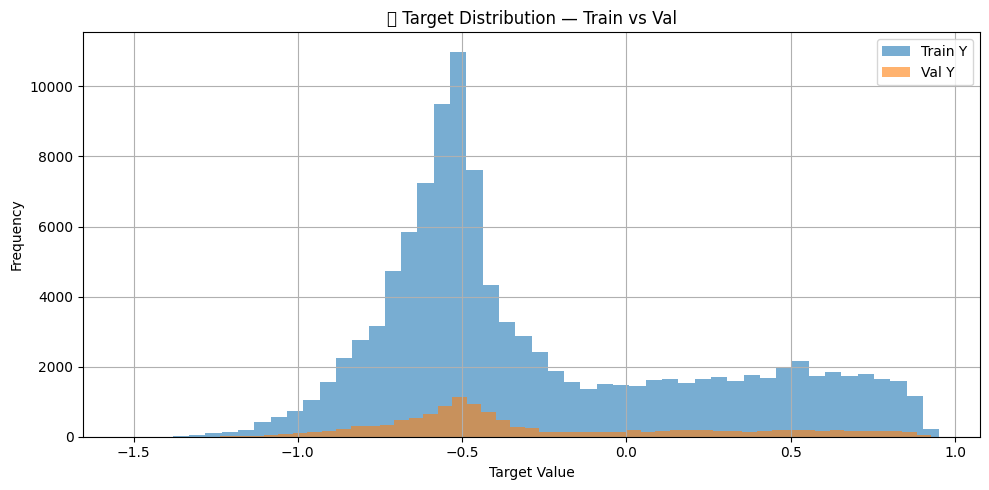

Epochs:   0%|          | 2/3000 [00:01<31:48,  1.57it/s]  

📉 Epoch 1 | Train Loss: 1.514185 | Val R2: -0.2216 | MAE: 0.5007 | MSE: 0.302064


Epochs:   3%|▎         | 101/3000 [00:14<06:40,  7.25it/s]

📉 Epoch 100 | Train Loss: 0.119096 | Val R2: 0.9371 | MAE: 0.0861 | MSE: 0.015561


Epochs:   7%|▋         | 201/3000 [00:28<06:27,  7.22it/s]

📉 Epoch 200 | Train Loss: 0.073226 | Val R2: 0.9651 | MAE: 0.0631 | MSE: 0.008633


Epochs:  10%|█         | 301/3000 [00:42<06:22,  7.06it/s]

📉 Epoch 300 | Train Loss: 0.054882 | Val R2: 0.9652 | MAE: 0.0612 | MSE: 0.008600


Epochs:  13%|█▎        | 401/3000 [00:56<06:08,  7.06it/s]

📉 Epoch 400 | Train Loss: 0.046671 | Val R2: 0.9593 | MAE: 0.0620 | MSE: 0.010071


Epochs:  17%|█▋        | 501/3000 [01:10<05:54,  7.04it/s]

📉 Epoch 500 | Train Loss: 0.037548 | Val R2: 0.9784 | MAE: 0.0511 | MSE: 0.005335


Epochs:  20%|██        | 601/3000 [01:24<05:40,  7.05it/s]

📉 Epoch 600 | Train Loss: 0.035290 | Val R2: 0.9770 | MAE: 0.0494 | MSE: 0.005687


Epochs:  23%|██▎       | 701/3000 [01:39<05:36,  6.84it/s]

📉 Epoch 700 | Train Loss: 0.028663 | Val R2: 0.9849 | MAE: 0.0413 | MSE: 0.003743


Epochs:  27%|██▋       | 801/3000 [01:53<05:22,  6.82it/s]

📉 Epoch 800 | Train Loss: 0.020415 | Val R2: 0.9858 | MAE: 0.0389 | MSE: 0.003523


Epochs:  30%|███       | 901/3000 [02:07<05:05,  6.86it/s]

📉 Epoch 900 | Train Loss: 0.043079 | Val R2: 0.9610 | MAE: 0.0616 | MSE: 0.009644


Epochs:  33%|███▎      | 1001/3000 [02:21<04:44,  7.02it/s]

📉 Epoch 1000 | Train Loss: 0.021584 | Val R2: 0.9839 | MAE: 0.0409 | MSE: 0.003986


Epochs:  37%|███▋      | 1101/3000 [02:35<04:30,  7.03it/s]

📉 Epoch 1100 | Train Loss: 0.013644 | Val R2: 0.9843 | MAE: 0.0406 | MSE: 0.003871


Epochs:  40%|████      | 1201/3000 [02:49<04:19,  6.95it/s]

📉 Epoch 1200 | Train Loss: 0.017157 | Val R2: 0.9790 | MAE: 0.0491 | MSE: 0.005198


Epochs:  43%|████▎     | 1301/3000 [03:04<04:03,  6.99it/s]

📉 Epoch 1300 | Train Loss: 0.037359 | Val R2: 0.9716 | MAE: 0.0515 | MSE: 0.007018


Epochs:  47%|████▋     | 1401/3000 [03:18<03:52,  6.87it/s]

📉 Epoch 1400 | Train Loss: 0.015512 | Val R2: 0.9801 | MAE: 0.0447 | MSE: 0.004917


Epochs:  49%|████▉     | 1473/3000 [03:28<03:36,  7.06it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0056184307, 'MAE': 0.047606383, 'R2': 0.9772771339040813}
💾 Сохранена новая лучшая модель: /kaggle/working/best_input_seed436860_ELU_Adam.pth (R² = 0.9773)
✅ Done: input_seed436860
📊 Metrics: R²=0.9773 | MSE=0.005618 | MAE=0.047606

🌱 Starting training with seed 778371
✅ Данные загружены в модель:
X_train shape: torch.Size([437, 3, 9, 28])
X_val shape: torch.Size([49, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


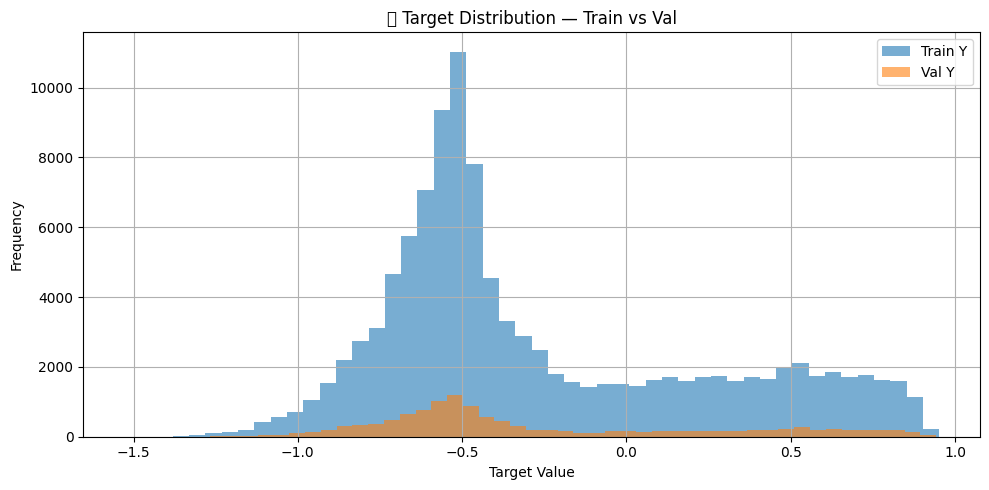

Epochs:   0%|          | 2/3000 [00:00<07:17,  6.85it/s]

📉 Epoch 1 | Train Loss: 1.674005 | Val R2: -0.2455 | MAE: 0.5261 | MSE: 0.327696


Epochs:   3%|▎         | 101/3000 [00:14<06:53,  7.01it/s]

📉 Epoch 100 | Train Loss: 0.103578 | Val R2: 0.9635 | MAE: 0.0709 | MSE: 0.009611


Epochs:   7%|▋         | 201/3000 [00:28<06:38,  7.02it/s]

📉 Epoch 200 | Train Loss: 0.057662 | Val R2: 0.9795 | MAE: 0.0495 | MSE: 0.005406


Epochs:  10%|█         | 301/3000 [00:42<06:24,  7.02it/s]

📉 Epoch 300 | Train Loss: 0.050483 | Val R2: 0.9758 | MAE: 0.0561 | MSE: 0.006362


Epochs:  13%|█▎        | 401/3000 [00:56<06:13,  6.97it/s]

📉 Epoch 400 | Train Loss: 0.035359 | Val R2: 0.9847 | MAE: 0.0436 | MSE: 0.004026


Epochs:  17%|█▋        | 501/3000 [01:11<05:58,  6.97it/s]

📉 Epoch 500 | Train Loss: 0.034350 | Val R2: 0.9862 | MAE: 0.0417 | MSE: 0.003624


Epochs:  20%|██        | 601/3000 [01:25<05:45,  6.95it/s]

📉 Epoch 600 | Train Loss: 0.036274 | Val R2: 0.9889 | MAE: 0.0388 | MSE: 0.002919


Epochs:  23%|██▎       | 701/3000 [01:39<05:33,  6.89it/s]

📉 Epoch 700 | Train Loss: 0.028181 | Val R2: 0.9883 | MAE: 0.0399 | MSE: 0.003088


Epochs:  27%|██▋       | 801/3000 [01:53<05:14,  6.99it/s]

📉 Epoch 800 | Train Loss: 0.014117 | Val R2: 0.9922 | MAE: 0.0312 | MSE: 0.002061


Epochs:  30%|███       | 901/3000 [02:07<05:03,  6.92it/s]

📉 Epoch 900 | Train Loss: 0.016759 | Val R2: 0.9857 | MAE: 0.0415 | MSE: 0.003753


Epochs:  33%|███▎      | 1001/3000 [02:21<04:48,  6.92it/s]

📉 Epoch 1000 | Train Loss: 0.033511 | Val R2: 0.9883 | MAE: 0.0413 | MSE: 0.003083


Epochs:  37%|███▋      | 1101/3000 [02:36<04:32,  6.98it/s]

📉 Epoch 1100 | Train Loss: 0.014260 | Val R2: 0.9913 | MAE: 0.0339 | MSE: 0.002293


Epochs:  40%|████      | 1201/3000 [02:50<04:17,  6.99it/s]

📉 Epoch 1200 | Train Loss: 0.013414 | Val R2: 0.9868 | MAE: 0.0397 | MSE: 0.003466


Epochs:  41%|████      | 1229/3000 [02:54<04:11,  7.04it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0024162778, 'MAE': 0.03359553, 'R2': 0.9908162585296872}
💾 Сохранена новая лучшая модель: /kaggle/working/best_input_seed778371_ELU_Adam.pth (R² = 0.9908)
✅ Done: input_seed778371
📊 Metrics: R²=0.9908 | MSE=0.002416 | MAE=0.033596

🌱 Starting training with seed 43582
✅ Данные загружены в модель:
X_train shape: torch.Size([437, 3, 9, 28])
X_val shape: torch.Size([49, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


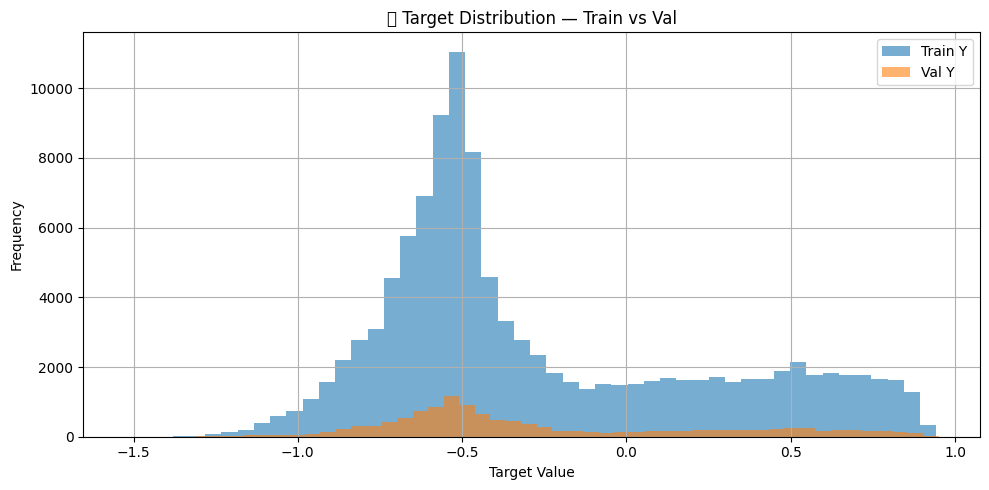

Epochs:   0%|          | 2/3000 [00:00<07:09,  6.99it/s]

📉 Epoch 1 | Train Loss: 1.574239 | Val R2: -0.3311 | MAE: 0.5226 | MSE: 0.326863


Epochs:   3%|▎         | 101/3000 [00:14<06:58,  6.93it/s]

📉 Epoch 100 | Train Loss: 0.096432 | Val R2: 0.9535 | MAE: 0.0743 | MSE: 0.011411


Epochs:   7%|▋         | 201/3000 [00:28<06:44,  6.92it/s]

📉 Epoch 200 | Train Loss: 0.103171 | Val R2: 0.9565 | MAE: 0.0735 | MSE: 0.010674


Epochs:  10%|█         | 301/3000 [00:42<06:30,  6.91it/s]

📉 Epoch 300 | Train Loss: 0.058194 | Val R2: 0.9740 | MAE: 0.0539 | MSE: 0.006375


Epochs:  13%|█▎        | 401/3000 [00:56<06:10,  7.01it/s]

📉 Epoch 400 | Train Loss: 0.062270 | Val R2: 0.9788 | MAE: 0.0497 | MSE: 0.005206


Epochs:  17%|█▋        | 501/3000 [01:11<06:04,  6.86it/s]

📉 Epoch 500 | Train Loss: 0.031321 | Val R2: 0.9822 | MAE: 0.0449 | MSE: 0.004374


Epochs:  20%|██        | 601/3000 [01:25<05:44,  6.97it/s]

📉 Epoch 600 | Train Loss: 0.028700 | Val R2: 0.9823 | MAE: 0.0436 | MSE: 0.004344


Epochs:  23%|██▎       | 701/3000 [01:39<05:30,  6.95it/s]

📉 Epoch 700 | Train Loss: 0.027075 | Val R2: 0.9833 | MAE: 0.0419 | MSE: 0.004106


Epochs:  27%|██▋       | 801/3000 [01:53<05:16,  6.94it/s]

📉 Epoch 800 | Train Loss: 0.042749 | Val R2: 0.9810 | MAE: 0.0458 | MSE: 0.004659


Epochs:  30%|███       | 901/3000 [02:07<05:00,  6.99it/s]

📉 Epoch 900 | Train Loss: 0.019996 | Val R2: 0.9869 | MAE: 0.0378 | MSE: 0.003216


Epochs:  33%|███▎      | 1001/3000 [02:21<04:47,  6.95it/s]

📉 Epoch 1000 | Train Loss: 0.026360 | Val R2: 0.9798 | MAE: 0.0444 | MSE: 0.004951


Epochs:  37%|███▋      | 1101/3000 [02:36<04:34,  6.91it/s]

📉 Epoch 1100 | Train Loss: 0.015013 | Val R2: 0.9904 | MAE: 0.0316 | MSE: 0.002352


Epochs:  40%|████      | 1201/3000 [02:50<04:17,  6.99it/s]

📉 Epoch 1200 | Train Loss: 0.016496 | Val R2: 0.9863 | MAE: 0.0362 | MSE: 0.003360


Epochs:  42%|████▏     | 1249/3000 [02:57<04:08,  7.04it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0035640388, 'MAE': 0.03886437, 'R2': 0.9854859461549782}
✅ Done: input_seed43582
📊 Metrics: R²=0.9855 | MSE=0.003564 | MAE=0.038864

🌱 Starting training with seed 704242
✅ Данные загружены в модель:
X_train shape: torch.Size([437, 3, 9, 28])
X_val shape: torch.Size([49, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


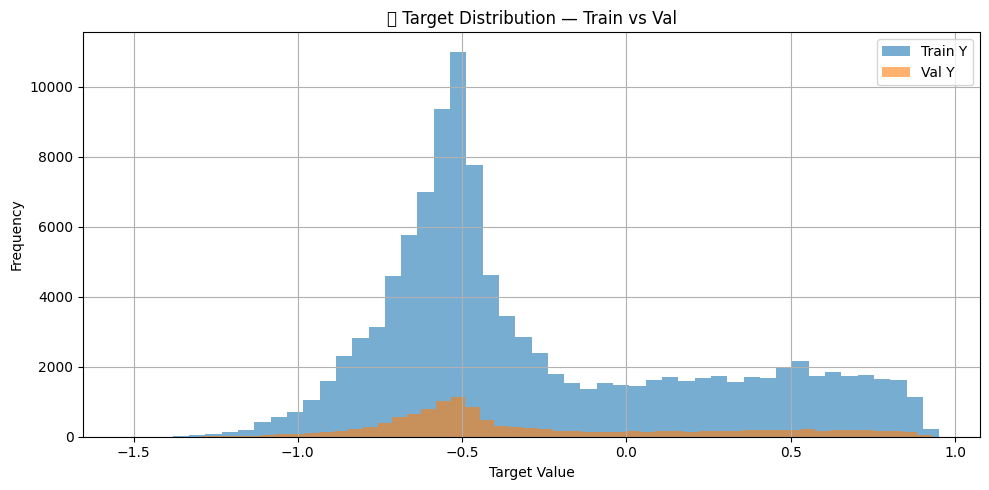

Epochs:   0%|          | 2/3000 [00:00<07:21,  6.79it/s]

📉 Epoch 1 | Train Loss: 1.801083 | Val R2: -0.3248 | MAE: 0.5318 | MSE: 0.337830


Epochs:   3%|▎         | 101/3000 [00:14<06:54,  7.00it/s]

📉 Epoch 100 | Train Loss: 0.157163 | Val R2: 0.9543 | MAE: 0.0749 | MSE: 0.011664


Epochs:   7%|▋         | 201/3000 [00:28<06:43,  6.93it/s]

📉 Epoch 200 | Train Loss: 0.059693 | Val R2: 0.9706 | MAE: 0.0602 | MSE: 0.007503


Epochs:  10%|█         | 301/3000 [00:42<06:30,  6.92it/s]

📉 Epoch 300 | Train Loss: 0.054374 | Val R2: 0.9640 | MAE: 0.0660 | MSE: 0.009172


Epochs:  13%|█▎        | 401/3000 [00:56<06:15,  6.92it/s]

📉 Epoch 400 | Train Loss: 0.046608 | Val R2: 0.9780 | MAE: 0.0502 | MSE: 0.005622


Epochs:  17%|█▋        | 501/3000 [01:11<05:59,  6.95it/s]

📉 Epoch 500 | Train Loss: 0.037356 | Val R2: 0.9762 | MAE: 0.0530 | MSE: 0.006063


Epochs:  20%|██        | 601/3000 [01:25<05:43,  6.97it/s]

📉 Epoch 600 | Train Loss: 0.025542 | Val R2: 0.9821 | MAE: 0.0451 | MSE: 0.004554


Epochs:  23%|██▎       | 701/3000 [01:39<05:29,  6.99it/s]

📉 Epoch 700 | Train Loss: 0.022652 | Val R2: 0.9862 | MAE: 0.0391 | MSE: 0.003530


Epochs:  27%|██▋       | 801/3000 [01:53<05:17,  6.93it/s]

📉 Epoch 800 | Train Loss: 0.024302 | Val R2: 0.9828 | MAE: 0.0444 | MSE: 0.004392


Epochs:  30%|███       | 901/3000 [02:07<05:05,  6.88it/s]

📉 Epoch 900 | Train Loss: 0.039352 | Val R2: 0.9780 | MAE: 0.0494 | MSE: 0.005602


Epochs:  33%|███▎      | 1001/3000 [02:22<04:46,  6.98it/s]

📉 Epoch 1000 | Train Loss: 0.015298 | Val R2: 0.9873 | MAE: 0.0375 | MSE: 0.003241


Epochs:  37%|███▋      | 1101/3000 [02:36<04:37,  6.85it/s]

📉 Epoch 1100 | Train Loss: 0.023370 | Val R2: 0.9840 | MAE: 0.0419 | MSE: 0.004092


Epochs:  40%|████      | 1201/3000 [02:50<04:19,  6.93it/s]

📉 Epoch 1200 | Train Loss: 0.014427 | Val R2: 0.9872 | MAE: 0.0372 | MSE: 0.003268


Epochs:  43%|████▎     | 1301/3000 [03:04<04:06,  6.90it/s]

📉 Epoch 1300 | Train Loss: 0.027830 | Val R2: 0.9866 | MAE: 0.0394 | MSE: 0.003426


Epochs:  45%|████▍     | 1343/3000 [03:10<03:55,  7.04it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0031071685, 'MAE': 0.037010066, 'R2': 0.9878148036583496}
✅ Done: input_seed704242
📊 Metrics: R²=0.9878 | MSE=0.003107 | MAE=0.037010

🌱 Starting training with seed 535149
✅ Данные загружены в модель:
X_train shape: torch.Size([437, 3, 9, 28])
X_val shape: torch.Size([49, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


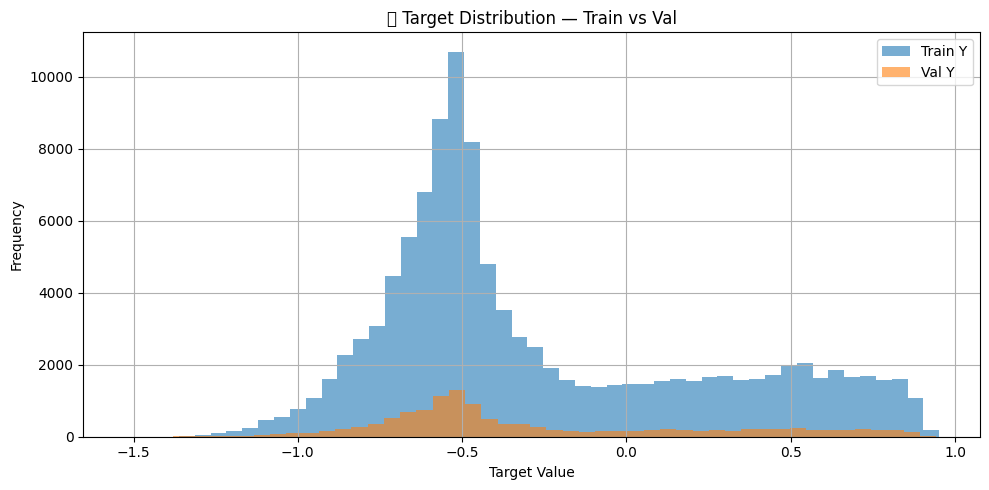

Epochs:   0%|          | 2/3000 [00:00<07:25,  6.73it/s]

📉 Epoch 1 | Train Loss: 1.602032 | Val R2: -0.3042 | MAE: 0.5246 | MSE: 0.329902


Epochs:   3%|▎         | 101/3000 [00:14<06:57,  6.94it/s]

📉 Epoch 100 | Train Loss: 0.092360 | Val R2: 0.9618 | MAE: 0.0657 | MSE: 0.009651


Epochs:   7%|▋         | 201/3000 [00:28<06:43,  6.94it/s]

📉 Epoch 200 | Train Loss: 0.077701 | Val R2: 0.9775 | MAE: 0.0544 | MSE: 0.005696


Epochs:  10%|█         | 301/3000 [00:42<06:26,  6.98it/s]

📉 Epoch 300 | Train Loss: 0.055195 | Val R2: 0.9762 | MAE: 0.0543 | MSE: 0.006011


Epochs:  13%|█▎        | 401/3000 [00:56<06:16,  6.91it/s]

📉 Epoch 400 | Train Loss: 0.050435 | Val R2: 0.9816 | MAE: 0.0477 | MSE: 0.004658


Epochs:  17%|█▋        | 501/3000 [01:11<06:05,  6.85it/s]

📉 Epoch 500 | Train Loss: 0.028493 | Val R2: 0.9897 | MAE: 0.0358 | MSE: 0.002597


Epochs:  20%|██        | 601/3000 [01:25<05:48,  6.88it/s]

📉 Epoch 600 | Train Loss: 0.028791 | Val R2: 0.9879 | MAE: 0.0383 | MSE: 0.003071


Epochs:  23%|██▎       | 701/3000 [01:39<05:30,  6.96it/s]

📉 Epoch 700 | Train Loss: 0.027260 | Val R2: 0.9888 | MAE: 0.0373 | MSE: 0.002829


Epochs:  27%|██▋       | 801/3000 [01:53<05:17,  6.93it/s]

📉 Epoch 800 | Train Loss: 0.018189 | Val R2: 0.9880 | MAE: 0.0359 | MSE: 0.003028


Epochs:  30%|███       | 901/3000 [02:07<05:01,  6.95it/s]

📉 Epoch 900 | Train Loss: 0.020906 | Val R2: 0.9894 | MAE: 0.0342 | MSE: 0.002670


Epochs:  33%|███▎      | 976/3000 [02:18<04:47,  7.04it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.004033823, 'MAE': 0.04021436, 'R2': 0.9840527031938233}
✅ Done: input_seed535149
📊 Metrics: R²=0.9841 | MSE=0.004034 | MAE=0.040214

🌱 Starting training with seed 391912
✅ Данные загружены в модель:
X_train shape: torch.Size([437, 3, 9, 28])
X_val shape: torch.Size([49, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


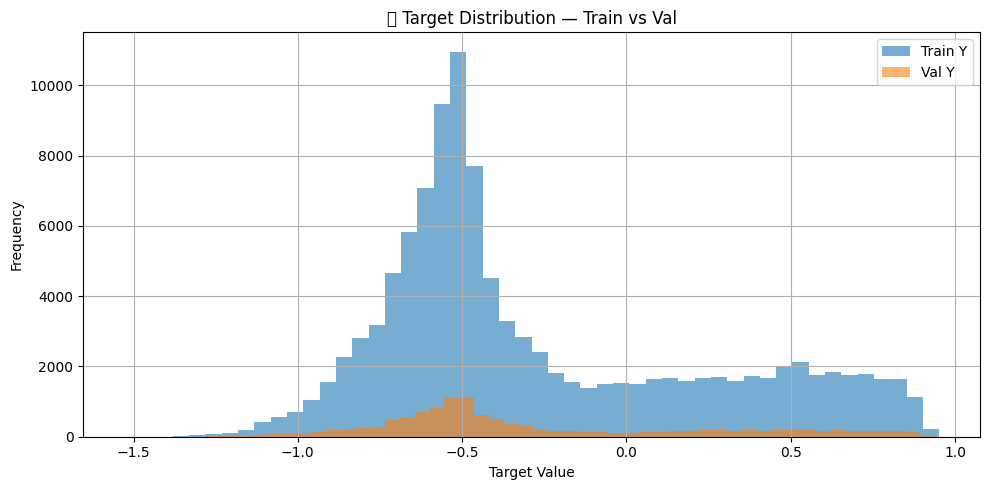

Epochs:   0%|          | 2/3000 [00:00<07:24,  6.75it/s]

📉 Epoch 1 | Train Loss: 1.559360 | Val R2: -0.2321 | MAE: 0.5100 | MSE: 0.311670


Epochs:   3%|▎         | 101/3000 [00:14<06:56,  6.95it/s]

📉 Epoch 100 | Train Loss: 0.140799 | Val R2: 0.9420 | MAE: 0.0827 | MSE: 0.014660


Epochs:   7%|▋         | 201/3000 [00:28<06:39,  7.01it/s]

📉 Epoch 200 | Train Loss: 0.096239 | Val R2: 0.9618 | MAE: 0.0681 | MSE: 0.009654


Epochs:  10%|█         | 301/3000 [00:42<06:34,  6.85it/s]

📉 Epoch 300 | Train Loss: 0.071624 | Val R2: 0.9688 | MAE: 0.0595 | MSE: 0.007897


Epochs:  13%|█▎        | 401/3000 [00:56<06:11,  6.99it/s]

📉 Epoch 400 | Train Loss: 0.055396 | Val R2: 0.9673 | MAE: 0.0575 | MSE: 0.008269


Epochs:  17%|█▋        | 501/3000 [01:11<05:57,  7.00it/s]

📉 Epoch 500 | Train Loss: 0.067638 | Val R2: 0.9664 | MAE: 0.0642 | MSE: 0.008487


Epochs:  20%|██        | 601/3000 [01:25<05:42,  7.00it/s]

📉 Epoch 600 | Train Loss: 0.040196 | Val R2: 0.9785 | MAE: 0.0466 | MSE: 0.005427


Epochs:  23%|██▎       | 701/3000 [01:39<05:31,  6.93it/s]

📉 Epoch 700 | Train Loss: 0.026383 | Val R2: 0.9692 | MAE: 0.0585 | MSE: 0.007793


Epochs:  26%|██▌       | 766/3000 [01:48<05:17,  7.03it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.004715014, 'MAE': 0.041205794, 'R2': 0.9813606146152198}
✅ Done: input_seed391912
📊 Metrics: R²=0.9814 | MSE=0.004715 | MAE=0.041206

🌱 Starting training with seed 565366
✅ Данные загружены в модель:
X_train shape: torch.Size([437, 3, 9, 28])
X_val shape: torch.Size([49, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


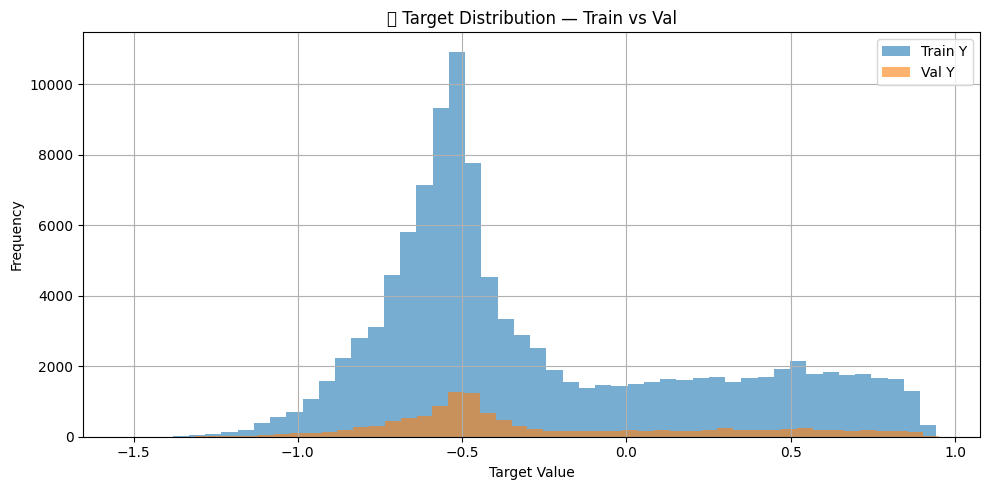

Epochs:   0%|          | 2/3000 [00:00<07:12,  6.93it/s]

📉 Epoch 1 | Train Loss: 1.735637 | Val R2: -0.2400 | MAE: 0.5001 | MSE: 0.302549


Epochs:   3%|▎         | 101/3000 [00:14<06:57,  6.94it/s]

📉 Epoch 100 | Train Loss: 0.094511 | Val R2: 0.9567 | MAE: 0.0690 | MSE: 0.010571


Epochs:   7%|▋         | 201/3000 [00:28<06:41,  6.97it/s]

📉 Epoch 200 | Train Loss: 0.057488 | Val R2: 0.9582 | MAE: 0.0634 | MSE: 0.010208


Epochs:  10%|█         | 301/3000 [00:42<06:28,  6.95it/s]

📉 Epoch 300 | Train Loss: 0.055120 | Val R2: 0.9630 | MAE: 0.0648 | MSE: 0.009027


Epochs:  13%|█▎        | 401/3000 [00:56<06:10,  7.01it/s]

📉 Epoch 400 | Train Loss: 0.054112 | Val R2: 0.9752 | MAE: 0.0508 | MSE: 0.006052


Epochs:  17%|█▋        | 501/3000 [01:11<06:01,  6.90it/s]

📉 Epoch 500 | Train Loss: 0.046417 | Val R2: 0.9768 | MAE: 0.0511 | MSE: 0.005653


Epochs:  20%|██        | 601/3000 [01:25<05:43,  6.98it/s]

📉 Epoch 600 | Train Loss: 0.030151 | Val R2: 0.9783 | MAE: 0.0428 | MSE: 0.005286


Epochs:  23%|██▎       | 701/3000 [01:39<05:32,  6.91it/s]

📉 Epoch 700 | Train Loss: 0.023184 | Val R2: 0.9794 | MAE: 0.0460 | MSE: 0.005033


Epochs:  27%|██▋       | 801/3000 [01:53<05:16,  6.95it/s]

📉 Epoch 800 | Train Loss: 0.038096 | Val R2: 0.9831 | MAE: 0.0404 | MSE: 0.004133


Epochs:  30%|███       | 901/3000 [02:07<05:04,  6.89it/s]

📉 Epoch 900 | Train Loss: 0.066765 | Val R2: 0.9722 | MAE: 0.0609 | MSE: 0.006785


Epochs:  30%|███       | 904/3000 [02:08<04:57,  7.04it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.003913354, 'MAE': 0.040158294, 'R2': 0.9839617065504872}
✅ Done: input_seed565366
📊 Metrics: R²=0.9840 | MSE=0.003913 | MAE=0.040158

🌱 Starting training with seed 687304
✅ Данные загружены в модель:
X_train shape: torch.Size([437, 3, 9, 28])
X_val shape: torch.Size([49, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


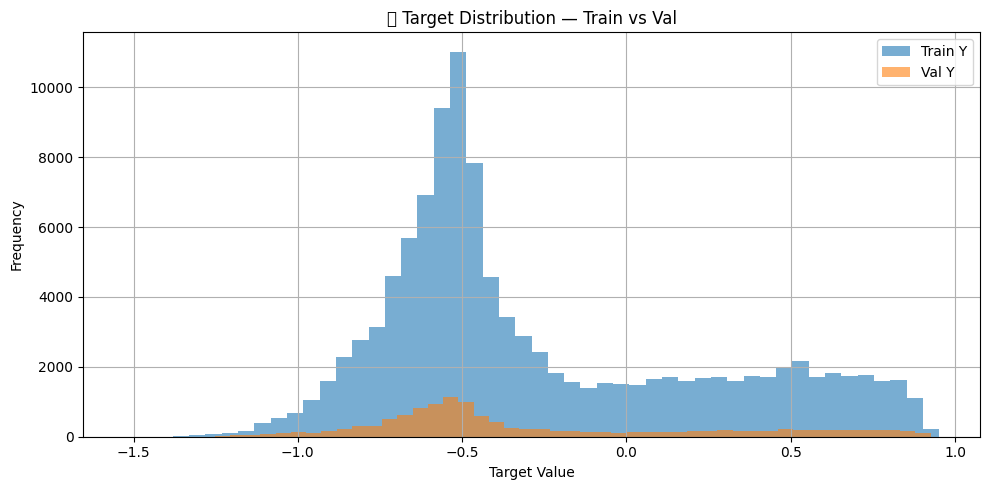

Epochs:   0%|          | 2/3000 [00:00<07:14,  6.89it/s]

📉 Epoch 1 | Train Loss: 1.559827 | Val R2: -0.1863 | MAE: 0.5179 | MSE: 0.321297


Epochs:   3%|▎         | 101/3000 [00:14<06:57,  6.95it/s]

📉 Epoch 100 | Train Loss: 0.105109 | Val R2: 0.9553 | MAE: 0.0733 | MSE: 0.012108


Epochs:   7%|▋         | 201/3000 [00:28<06:41,  6.97it/s]

📉 Epoch 200 | Train Loss: 0.074940 | Val R2: 0.9687 | MAE: 0.0617 | MSE: 0.008473


Epochs:  10%|█         | 301/3000 [00:42<06:27,  6.96it/s]

📉 Epoch 300 | Train Loss: 0.112561 | Val R2: 0.9570 | MAE: 0.0752 | MSE: 0.011655


Epochs:  13%|█▎        | 401/3000 [00:56<06:15,  6.92it/s]

📉 Epoch 400 | Train Loss: 0.047370 | Val R2: 0.9753 | MAE: 0.0556 | MSE: 0.006701


Epochs:  17%|█▋        | 501/3000 [01:11<05:59,  6.95it/s]

📉 Epoch 500 | Train Loss: 0.036605 | Val R2: 0.9740 | MAE: 0.0549 | MSE: 0.007036


Epochs:  20%|██        | 601/3000 [01:25<05:42,  7.00it/s]

📉 Epoch 600 | Train Loss: 0.053821 | Val R2: 0.9769 | MAE: 0.0517 | MSE: 0.006266


Epochs:  23%|██▎       | 701/3000 [01:39<05:31,  6.93it/s]

📉 Epoch 700 | Train Loss: 0.043398 | Val R2: 0.9764 | MAE: 0.0508 | MSE: 0.006395


Epochs:  27%|██▋       | 801/3000 [01:53<05:12,  7.04it/s]

📉 Epoch 800 | Train Loss: 0.027854 | Val R2: 0.9821 | MAE: 0.0453 | MSE: 0.004857


Epochs:  30%|███       | 901/3000 [02:07<05:01,  6.97it/s]

📉 Epoch 900 | Train Loss: 0.030261 | Val R2: 0.9839 | MAE: 0.0432 | MSE: 0.004372


Epochs:  33%|███▎      | 1001/3000 [02:21<04:47,  6.95it/s]

📉 Epoch 1000 | Train Loss: 0.024782 | Val R2: 0.9819 | MAE: 0.0443 | MSE: 0.004893


Epochs:  37%|███▋      | 1101/3000 [02:36<04:34,  6.92it/s]

📉 Epoch 1100 | Train Loss: 0.022574 | Val R2: 0.9849 | MAE: 0.0401 | MSE: 0.004086


Epochs:  40%|████      | 1201/3000 [02:50<04:17,  6.98it/s]

📉 Epoch 1200 | Train Loss: 0.030527 | Val R2: 0.9802 | MAE: 0.0486 | MSE: 0.005366


Epochs:  43%|████▎     | 1301/3000 [03:04<04:06,  6.89it/s]

📉 Epoch 1300 | Train Loss: 0.020595 | Val R2: 0.9882 | MAE: 0.0369 | MSE: 0.003202


Epochs:  47%|████▋     | 1401/3000 [03:18<03:48,  7.01it/s]

📉 Epoch 1400 | Train Loss: 0.018306 | Val R2: 0.9880 | MAE: 0.0372 | MSE: 0.003238


Epochs:  50%|█████     | 1501/3000 [03:32<03:36,  6.92it/s]

📉 Epoch 1500 | Train Loss: 0.014747 | Val R2: 0.9878 | MAE: 0.0367 | MSE: 0.003297


Epochs:  51%|█████     | 1517/3000 [03:35<03:30,  7.05it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.011879278, 'MAE': 0.053320132, 'R2': 0.9561387859694159}
✅ Done: input_seed687304
📊 Metrics: R²=0.9561 | MSE=0.011879 | MAE=0.053320

🌱 Starting training with seed 589406
✅ Данные загружены в модель:
X_train shape: torch.Size([437, 3, 9, 28])
X_val shape: torch.Size([49, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


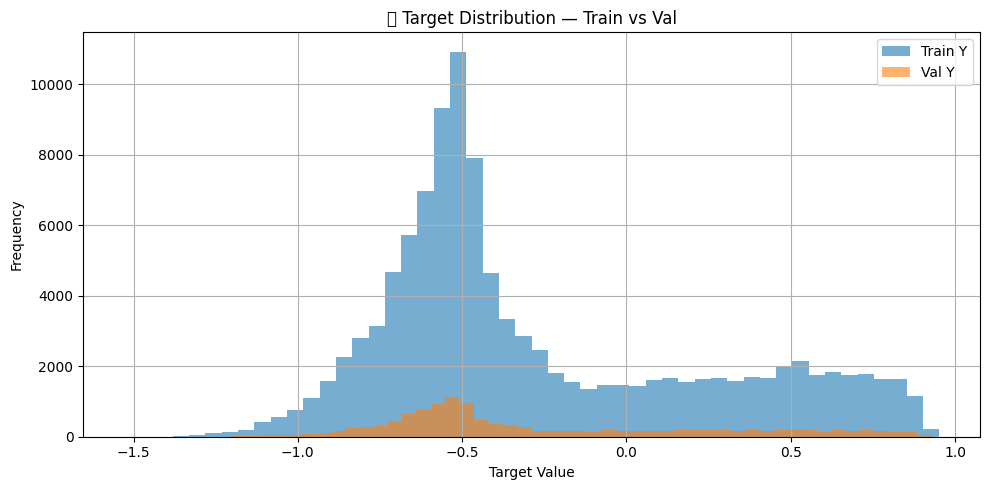

Epochs:   0%|          | 2/3000 [00:00<07:15,  6.89it/s]

📉 Epoch 1 | Train Loss: 1.626819 | Val R2: -0.3273 | MAE: 0.5229 | MSE: 0.328647


Epochs:   3%|▎         | 101/3000 [00:14<07:00,  6.90it/s]

📉 Epoch 100 | Train Loss: 0.093040 | Val R2: 0.9578 | MAE: 0.0761 | MSE: 0.010454


Epochs:   7%|▋         | 201/3000 [00:28<06:41,  6.98it/s]

📉 Epoch 200 | Train Loss: 0.058896 | Val R2: 0.9756 | MAE: 0.0554 | MSE: 0.006032


Epochs:  10%|█         | 301/3000 [00:42<06:31,  6.89it/s]

📉 Epoch 300 | Train Loss: 0.047117 | Val R2: 0.9821 | MAE: 0.0476 | MSE: 0.004435


Epochs:  13%|█▎        | 401/3000 [00:56<06:11,  6.99it/s]

📉 Epoch 400 | Train Loss: 0.046827 | Val R2: 0.9817 | MAE: 0.0443 | MSE: 0.004525


Epochs:  17%|█▋        | 501/3000 [01:11<05:59,  6.95it/s]

📉 Epoch 500 | Train Loss: 0.029860 | Val R2: 0.9846 | MAE: 0.0404 | MSE: 0.003823


Epochs:  20%|██        | 601/3000 [01:25<05:45,  6.95it/s]

📉 Epoch 600 | Train Loss: 0.026486 | Val R2: 0.9863 | MAE: 0.0398 | MSE: 0.003388


Epochs:  22%|██▏       | 660/3000 [01:33<05:32,  7.03it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0050689657, 'MAE': 0.04783836, 'R2': 0.9795279337062763}
✅ Done: input_seed589406
📊 Metrics: R²=0.9795 | MSE=0.005069 | MAE=0.047838

🌱 Starting training with seed 492989
✅ Данные загружены в модель:
X_train shape: torch.Size([437, 3, 9, 28])
X_val shape: torch.Size([49, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


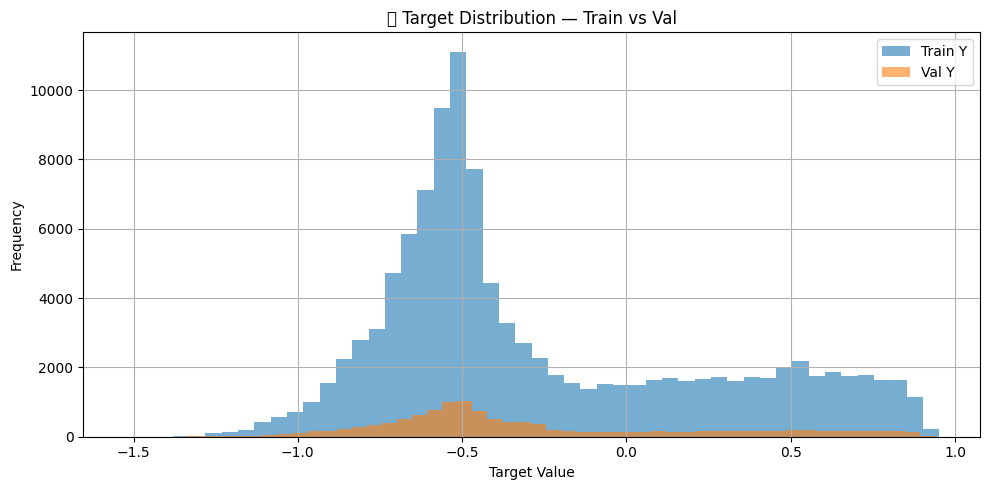

Epochs:   0%|          | 2/3000 [00:00<07:14,  6.90it/s]

📉 Epoch 1 | Train Loss: 1.450748 | Val R2: -0.2977 | MAE: 0.5112 | MSE: 0.314810


Epochs:   3%|▎         | 101/3000 [00:14<06:54,  6.99it/s]

📉 Epoch 100 | Train Loss: 0.115471 | Val R2: 0.9356 | MAE: 0.0840 | MSE: 0.015615


Epochs:   7%|▋         | 201/3000 [00:28<06:45,  6.90it/s]

📉 Epoch 200 | Train Loss: 0.053084 | Val R2: 0.9517 | MAE: 0.0687 | MSE: 0.011714


Epochs:  10%|█         | 301/3000 [00:42<06:33,  6.86it/s]

📉 Epoch 300 | Train Loss: 0.047019 | Val R2: 0.9544 | MAE: 0.0684 | MSE: 0.011057


Epochs:  13%|█▎        | 401/3000 [00:56<06:12,  6.98it/s]

📉 Epoch 400 | Train Loss: 0.047378 | Val R2: 0.9598 | MAE: 0.0563 | MSE: 0.009747


Epochs:  17%|█▋        | 501/3000 [01:11<06:02,  6.89it/s]

📉 Epoch 500 | Train Loss: 0.048135 | Val R2: 0.9574 | MAE: 0.0626 | MSE: 0.010335


Epochs:  20%|██        | 601/3000 [01:25<05:46,  6.92it/s]

📉 Epoch 600 | Train Loss: 0.042026 | Val R2: 0.9619 | MAE: 0.0585 | MSE: 0.009237


Epochs:  23%|██▎       | 701/3000 [01:39<05:29,  6.99it/s]

📉 Epoch 700 | Train Loss: 0.022619 | Val R2: 0.9665 | MAE: 0.0516 | MSE: 0.008123


Epochs:  27%|██▋       | 801/3000 [01:53<05:13,  7.01it/s]

📉 Epoch 800 | Train Loss: 0.028918 | Val R2: 0.9597 | MAE: 0.0584 | MSE: 0.009775


Epochs:  30%|███       | 901/3000 [02:07<05:08,  6.79it/s]

📉 Epoch 900 | Train Loss: 0.057831 | Val R2: 0.9594 | MAE: 0.0584 | MSE: 0.009839


Epochs:  33%|███▎      | 1001/3000 [02:21<04:44,  7.04it/s]

📉 Epoch 1000 | Train Loss: 0.024433 | Val R2: 0.9423 | MAE: 0.0583 | MSE: 0.013989


Epochs:  37%|███▋      | 1101/3000 [02:36<04:32,  6.96it/s]

📉 Epoch 1100 | Train Loss: 0.016393 | Val R2: 0.9718 | MAE: 0.0465 | MSE: 0.006830


Epochs:  40%|███▉      | 1199/3000 [02:50<04:15,  7.05it/s]


📉 Epoch 1200 | Train Loss: 0.013425 | Val R2: 0.9655 | MAE: 0.0476 | MSE: 0.008359
⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.008358838, 'MAE': 0.047581602, 'R2': 0.9655423358630163}
✅ Done: input_seed492989
📊 Metrics: R²=0.9655 | MSE=0.008359 | MAE=0.047582

🌱 Starting training with seed 344878
✅ Данные загружены в модель:
X_train shape: torch.Size([437, 3, 9, 28])
X_val shape: torch.Size([49, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


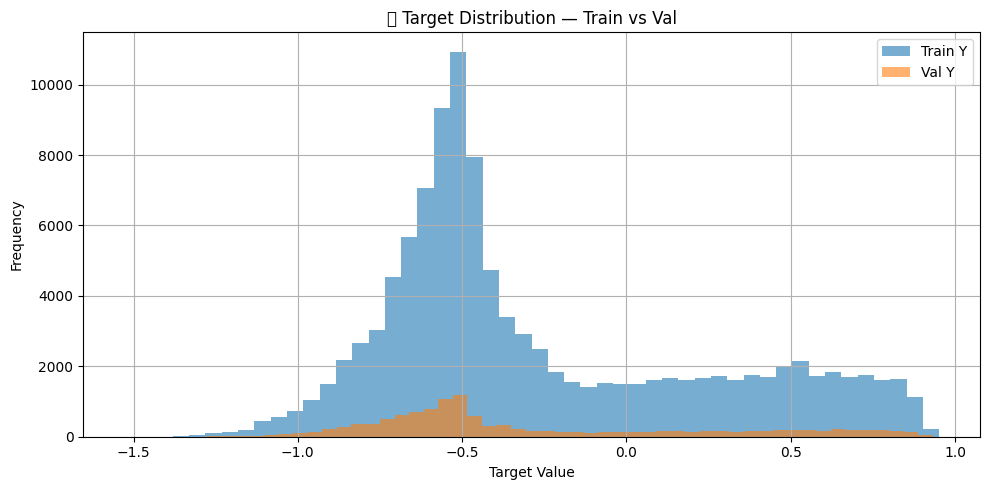

Epochs:   0%|          | 2/3000 [00:00<07:17,  6.86it/s]

📉 Epoch 1 | Train Loss: 1.749787 | Val R2: -0.5370 | MAE: 0.5873 | MSE: 0.410574


Epochs:   3%|▎         | 101/3000 [00:14<06:57,  6.94it/s]

📉 Epoch 100 | Train Loss: 0.083995 | Val R2: 0.9623 | MAE: 0.0643 | MSE: 0.010065


Epochs:   7%|▋         | 201/3000 [00:28<06:42,  6.96it/s]

📉 Epoch 200 | Train Loss: 0.067454 | Val R2: 0.9678 | MAE: 0.0627 | MSE: 0.008597


Epochs:  10%|█         | 301/3000 [00:42<06:27,  6.97it/s]

📉 Epoch 300 | Train Loss: 0.056325 | Val R2: 0.9710 | MAE: 0.0633 | MSE: 0.007740


Epochs:  13%|█▎        | 401/3000 [00:56<06:13,  6.95it/s]

📉 Epoch 400 | Train Loss: 0.044728 | Val R2: 0.9756 | MAE: 0.0539 | MSE: 0.006514


Epochs:  17%|█▋        | 501/3000 [01:11<05:55,  7.04it/s]

📉 Epoch 500 | Train Loss: 0.028512 | Val R2: 0.9841 | MAE: 0.0388 | MSE: 0.004238


Epochs:  20%|██        | 601/3000 [01:25<05:45,  6.94it/s]

📉 Epoch 600 | Train Loss: 0.026503 | Val R2: 0.9817 | MAE: 0.0417 | MSE: 0.004884


Epochs:  23%|██▎       | 701/3000 [01:39<05:31,  6.94it/s]

📉 Epoch 700 | Train Loss: 0.022965 | Val R2: 0.9836 | MAE: 0.0439 | MSE: 0.004378


Epochs:  25%|██▌       | 754/3000 [01:47<05:18,  7.04it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.003618215, 'MAE': 0.037839122, 'R2': 0.9864549933836554}
✅ Done: input_seed344878
📊 Metrics: R²=0.9865 | MSE=0.003618 | MAE=0.037839

🌱 Starting training with seed 605388
✅ Данные загружены в модель:
X_train shape: torch.Size([437, 3, 9, 28])
X_val shape: torch.Size([49, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


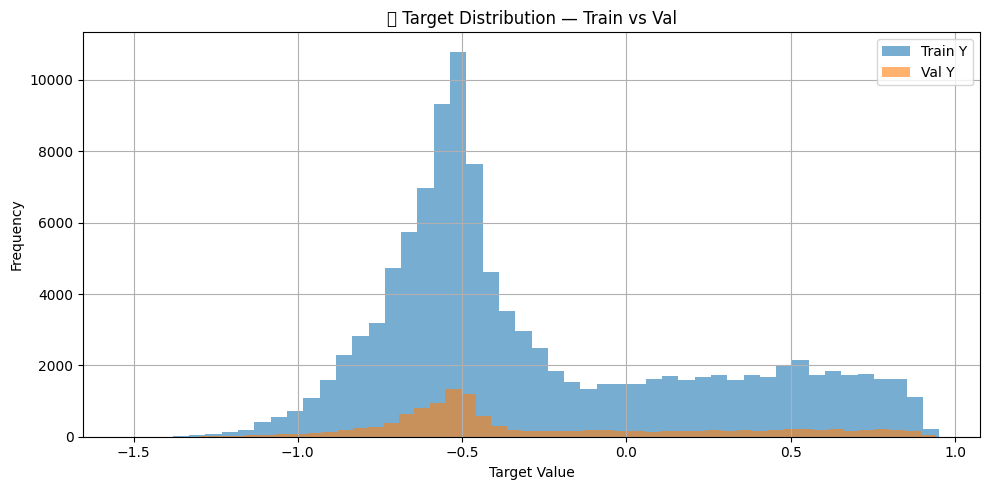

Epochs:   0%|          | 2/3000 [00:00<07:11,  6.95it/s]

📉 Epoch 1 | Train Loss: 1.637256 | Val R2: -0.1451 | MAE: 0.4974 | MSE: 0.298743


Epochs:   3%|▎         | 101/3000 [00:14<06:55,  6.97it/s]

📉 Epoch 100 | Train Loss: 0.144958 | Val R2: 0.9241 | MAE: 0.0999 | MSE: 0.019808


Epochs:   7%|▋         | 201/3000 [00:28<06:45,  6.90it/s]

📉 Epoch 200 | Train Loss: 0.075991 | Val R2: 0.9770 | MAE: 0.0543 | MSE: 0.006004


Epochs:  10%|█         | 301/3000 [00:42<06:26,  6.98it/s]

📉 Epoch 300 | Train Loss: 0.051164 | Val R2: 0.9796 | MAE: 0.0538 | MSE: 0.005315


Epochs:  13%|█▎        | 401/3000 [00:56<06:14,  6.95it/s]

📉 Epoch 400 | Train Loss: 0.040622 | Val R2: 0.9746 | MAE: 0.0504 | MSE: 0.006638


Epochs:  17%|█▋        | 501/3000 [01:11<05:56,  7.02it/s]

📉 Epoch 500 | Train Loss: 0.035573 | Val R2: 0.9822 | MAE: 0.0484 | MSE: 0.004640


Epochs:  20%|██        | 601/3000 [01:25<05:43,  6.98it/s]

📉 Epoch 600 | Train Loss: 0.040501 | Val R2: 0.9850 | MAE: 0.0418 | MSE: 0.003924


Epochs:  23%|██▎       | 701/3000 [01:39<05:34,  6.88it/s]

📉 Epoch 700 | Train Loss: 0.021629 | Val R2: 0.9887 | MAE: 0.0350 | MSE: 0.002948


Epochs:  27%|██▋       | 801/3000 [01:53<05:14,  7.00it/s]

📉 Epoch 800 | Train Loss: 0.023414 | Val R2: 0.9872 | MAE: 0.0381 | MSE: 0.003352


Epochs:  28%|██▊       | 854/3000 [02:01<05:04,  7.04it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0032892255, 'MAE': 0.037160985, 'R2': 0.9873919403734879}
✅ Done: input_seed605388
📊 Metrics: R²=0.9874 | MSE=0.003289 | MAE=0.037161

🌱 Starting training with seed 169904
✅ Данные загружены в модель:
X_train shape: torch.Size([437, 3, 9, 28])
X_val shape: torch.Size([49, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


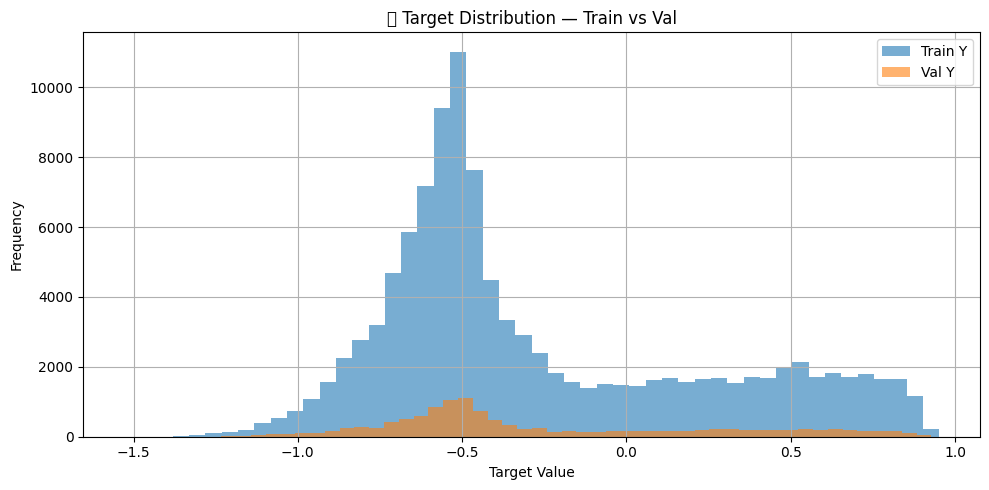

Epochs:   0%|          | 2/3000 [00:00<07:09,  6.98it/s]

📉 Epoch 1 | Train Loss: 1.551336 | Val R2: -0.1385 | MAE: 0.4866 | MSE: 0.286961


Epochs:   3%|▎         | 101/3000 [00:14<06:55,  6.98it/s]

📉 Epoch 100 | Train Loss: 0.137443 | Val R2: 0.9532 | MAE: 0.0773 | MSE: 0.011795


Epochs:   7%|▋         | 201/3000 [00:28<06:40,  6.99it/s]

📉 Epoch 200 | Train Loss: 0.062848 | Val R2: 0.9737 | MAE: 0.0557 | MSE: 0.006631


Epochs:  10%|█         | 301/3000 [00:42<06:24,  7.03it/s]

📉 Epoch 300 | Train Loss: 0.058927 | Val R2: 0.9641 | MAE: 0.0657 | MSE: 0.009041


Epochs:  13%|█▎        | 401/3000 [00:56<06:18,  6.86it/s]

📉 Epoch 400 | Train Loss: 0.050101 | Val R2: 0.9802 | MAE: 0.0461 | MSE: 0.004992


Epochs:  17%|█▋        | 501/3000 [01:11<05:59,  6.96it/s]

📉 Epoch 500 | Train Loss: 0.057020 | Val R2: 0.9581 | MAE: 0.0667 | MSE: 0.010570


Epochs:  20%|██        | 601/3000 [01:25<05:43,  6.99it/s]

📉 Epoch 600 | Train Loss: 0.032386 | Val R2: 0.9848 | MAE: 0.0397 | MSE: 0.003835


Epochs:  23%|██▎       | 701/3000 [01:39<05:27,  7.01it/s]

📉 Epoch 700 | Train Loss: 0.045348 | Val R2: 0.9845 | MAE: 0.0418 | MSE: 0.003917


Epochs:  27%|██▋       | 801/3000 [01:53<05:15,  6.96it/s]

📉 Epoch 800 | Train Loss: 0.026061 | Val R2: 0.9878 | MAE: 0.0368 | MSE: 0.003062


Epochs:  30%|███       | 901/3000 [02:07<05:01,  6.96it/s]

📉 Epoch 900 | Train Loss: 0.021545 | Val R2: 0.9887 | MAE: 0.0353 | MSE: 0.002841


Epochs:  33%|███▎      | 1001/3000 [02:22<04:49,  6.92it/s]

📉 Epoch 1000 | Train Loss: 0.013968 | Val R2: 0.9911 | MAE: 0.0318 | MSE: 0.002255


Epochs:  36%|███▋      | 1091/3000 [02:34<04:31,  7.04it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0026545313, 'MAE': 0.033805247, 'R2': 0.9894681485984483}
✅ Done: input_seed169904
📊 Metrics: R²=0.9895 | MSE=0.002655 | MAE=0.033805

🌱 Starting training with seed 987474
✅ Данные загружены в модель:
X_train shape: torch.Size([437, 3, 9, 28])
X_val shape: torch.Size([49, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


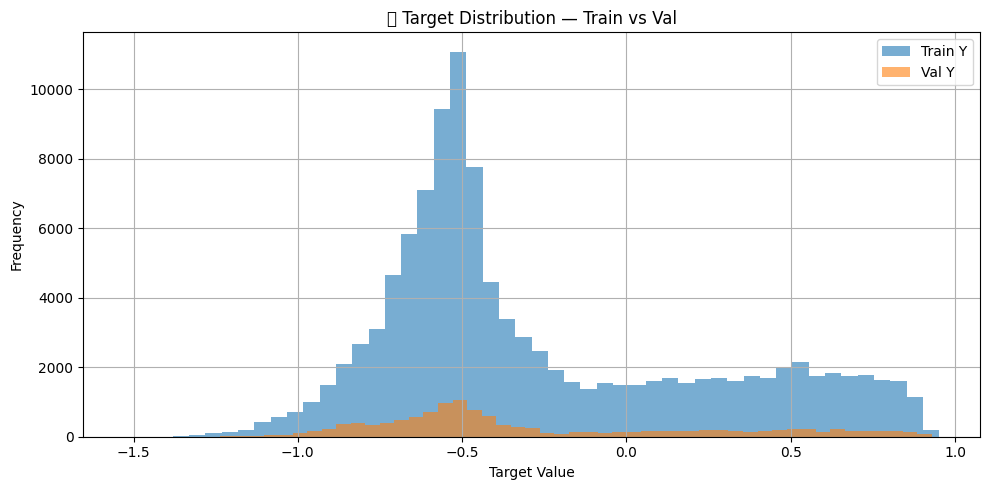

Epochs:   0%|          | 2/3000 [00:00<07:17,  6.85it/s]

📉 Epoch 1 | Train Loss: 1.546077 | Val R2: -0.1743 | MAE: 0.5067 | MSE: 0.307305


Epochs:   3%|▎         | 101/3000 [00:14<07:00,  6.90it/s]

📉 Epoch 100 | Train Loss: 0.116432 | Val R2: 0.9504 | MAE: 0.0816 | MSE: 0.012981


Epochs:   7%|▋         | 201/3000 [00:28<06:45,  6.90it/s]

📉 Epoch 200 | Train Loss: 0.070542 | Val R2: 0.9604 | MAE: 0.0688 | MSE: 0.010366


Epochs:  10%|█         | 301/3000 [00:42<06:29,  6.94it/s]

📉 Epoch 300 | Train Loss: 0.058944 | Val R2: 0.9695 | MAE: 0.0620 | MSE: 0.007970


Epochs:  13%|█▎        | 401/3000 [00:56<06:17,  6.89it/s]

📉 Epoch 400 | Train Loss: 0.053153 | Val R2: 0.9817 | MAE: 0.0489 | MSE: 0.004795


Epochs:  17%|█▋        | 501/3000 [01:11<05:59,  6.95it/s]

📉 Epoch 500 | Train Loss: 0.034772 | Val R2: 0.9836 | MAE: 0.0467 | MSE: 0.004288


Epochs:  20%|██        | 601/3000 [01:25<05:42,  7.00it/s]

📉 Epoch 600 | Train Loss: 0.030656 | Val R2: 0.9859 | MAE: 0.0430 | MSE: 0.003687


Epochs:  23%|██▎       | 701/3000 [01:39<05:33,  6.89it/s]

📉 Epoch 700 | Train Loss: 0.038449 | Val R2: 0.9813 | MAE: 0.0509 | MSE: 0.004889


Epochs:  27%|██▋       | 801/3000 [01:53<05:19,  6.87it/s]

📉 Epoch 800 | Train Loss: 0.025022 | Val R2: 0.9840 | MAE: 0.0435 | MSE: 0.004180


Epochs:  30%|███       | 901/3000 [02:07<05:04,  6.90it/s]

📉 Epoch 900 | Train Loss: 0.044356 | Val R2: 0.9789 | MAE: 0.0521 | MSE: 0.005512


Epochs:  33%|███▎      | 1001/3000 [02:22<04:47,  6.95it/s]

📉 Epoch 1000 | Train Loss: 0.021167 | Val R2: 0.9860 | MAE: 0.0415 | MSE: 0.003655


Epochs:  37%|███▋      | 1101/3000 [02:36<04:35,  6.89it/s]

📉 Epoch 1100 | Train Loss: 0.027525 | Val R2: 0.9846 | MAE: 0.0453 | MSE: 0.004020


Epochs:  40%|████      | 1201/3000 [02:50<04:21,  6.88it/s]

📉 Epoch 1200 | Train Loss: 0.015653 | Val R2: 0.9911 | MAE: 0.0325 | MSE: 0.002338


Epochs:  43%|████▎     | 1301/3000 [03:04<04:04,  6.95it/s]

📉 Epoch 1300 | Train Loss: 0.020023 | Val R2: 0.9913 | MAE: 0.0337 | MSE: 0.002267


Epochs:  45%|████▌     | 1355/3000 [03:12<03:53,  7.04it/s]


⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0020052206, 'MAE': 0.030485561, 'R2': 0.9923375510427701}
💾 Сохранена новая лучшая модель: /kaggle/working/best_input_seed987474_ELU_Adam.pth (R² = 0.9923)
✅ Done: input_seed987474
📊 Metrics: R²=0.9923 | MSE=0.002005 | MAE=0.030486

🌱 Starting training with seed 466711
✅ Данные загружены в модель:
X_train shape: torch.Size([437, 3, 9, 28])
X_val shape: torch.Size([49, 3, 9, 28])


/tmp/ipykernel_19/1404025780.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


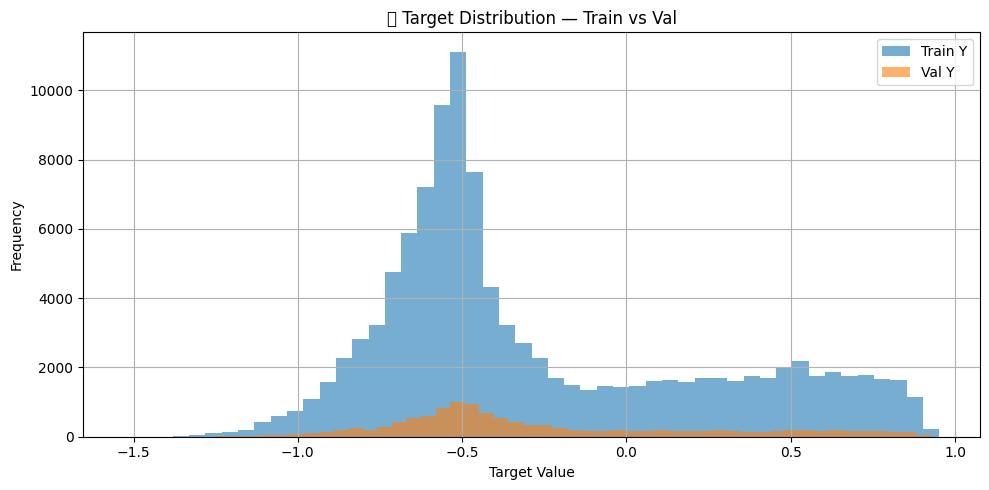

Epochs:   0%|          | 2/3000 [00:00<07:09,  6.99it/s]

📉 Epoch 1 | Train Loss: 1.437308 | Val R2: -0.2170 | MAE: 0.4764 | MSE: 0.279728


Epochs:   3%|▎         | 101/3000 [00:14<06:57,  6.94it/s]

📉 Epoch 100 | Train Loss: 0.112851 | Val R2: 0.9226 | MAE: 0.0879 | MSE: 0.017782


Epochs:   7%|▋         | 201/3000 [00:28<06:43,  6.94it/s]

📉 Epoch 200 | Train Loss: 0.084051 | Val R2: 0.9446 | MAE: 0.0730 | MSE: 0.012737


Epochs:  10%|█         | 301/3000 [00:42<06:28,  6.94it/s]

📉 Epoch 300 | Train Loss: 0.084659 | Val R2: 0.9616 | MAE: 0.0615 | MSE: 0.008824


Epochs:  13%|█▎        | 401/3000 [00:56<06:10,  7.02it/s]

📉 Epoch 400 | Train Loss: 0.049041 | Val R2: 0.9687 | MAE: 0.0566 | MSE: 0.007191


Epochs:  17%|█▋        | 501/3000 [01:11<05:59,  6.95it/s]

📉 Epoch 500 | Train Loss: 0.036949 | Val R2: 0.9724 | MAE: 0.0528 | MSE: 0.006344


Epochs:  20%|██        | 601/3000 [01:25<05:45,  6.94it/s]

📉 Epoch 600 | Train Loss: 0.083672 | Val R2: 0.9275 | MAE: 0.0848 | MSE: 0.016666


Epochs:  23%|██▎       | 701/3000 [01:39<05:31,  6.94it/s]

📉 Epoch 700 | Train Loss: 0.038179 | Val R2: 0.9707 | MAE: 0.0514 | MSE: 0.006744


Epochs:  27%|██▋       | 801/3000 [01:53<05:14,  6.99it/s]

📉 Epoch 800 | Train Loss: 0.025990 | Val R2: 0.9775 | MAE: 0.0458 | MSE: 0.005173


Epochs:  30%|███       | 901/3000 [02:07<05:02,  6.94it/s]

📉 Epoch 900 | Train Loss: 0.025897 | Val R2: 0.9761 | MAE: 0.0454 | MSE: 0.005484


Epochs:  33%|███▎      | 1001/3000 [02:21<04:48,  6.94it/s]

📉 Epoch 1000 | Train Loss: 0.019242 | Val R2: 0.9795 | MAE: 0.0425 | MSE: 0.004712


Epochs:  37%|███▋      | 1101/3000 [02:36<04:35,  6.89it/s]

📉 Epoch 1100 | Train Loss: 0.019250 | Val R2: 0.9803 | MAE: 0.0437 | MSE: 0.004530


Epochs:  40%|████      | 1201/3000 [02:50<04:18,  6.96it/s]

📉 Epoch 1200 | Train Loss: 0.020614 | Val R2: 0.9806 | MAE: 0.0415 | MSE: 0.004458


Epochs:  43%|████▎     | 1301/3000 [03:04<04:05,  6.93it/s]

📉 Epoch 1300 | Train Loss: 0.034943 | Val R2: 0.9796 | MAE: 0.0447 | MSE: 0.004686


Epochs:  47%|████▋     | 1401/3000 [03:18<03:49,  6.96it/s]

📉 Epoch 1400 | Train Loss: 0.016538 | Val R2: 0.9852 | MAE: 0.0375 | MSE: 0.003406


Epochs:  50%|█████     | 1501/3000 [03:32<03:35,  6.95it/s]

📉 Epoch 1500 | Train Loss: 0.022197 | Val R2: 0.9825 | MAE: 0.0426 | MSE: 0.004029


Epochs:  51%|█████     | 1526/3000 [03:36<03:29,  7.04it/s]

⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.0036781577, 'MAE': 0.038956825, 'R2': 0.9839977270392777}
✅ Done: input_seed466711
📊 Metrics: R²=0.9840 | MSE=0.003678 | MAE=0.038957

🏆 Лучший запуск:
🆔 Run ID: input_seed987474
📈 R²: 0.9923
📉 MAE: 0.0305
📉 MSE: 0.002005


In [6]:
all_results = []

# === Установка сидов
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# === Загрузка данных и конфига
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)


X_all = np.load(DATA_ROOT / "X_cnn_case_id.npy")
Y_all = np.load(DATA_ROOT / "Y_cnn_case_id.npy")

# === Цикл по сидом
NUM_RUNS = 15
random.seed(int(time.time()))  # или просто random.seed() для более случайной генерации
seeds = random.sample(range(1_000_000), NUM_RUNS)  # 10 уникальных случайных seed
base_run_id = CONFIG_PATH.parent.name
print('seeds:', seeds)

best_r2 = -np.inf

for seed in seeds:
    print(f"\n🌱 Starting training with seed {seed}")
    set_seed(seed)

    # 💡 Разбиение train/val с текущим сидом
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_all, Y_all, test_size=0.1, random_state=seed
    )

    # 🔁 Создание новой копии конфига
    config_run = config.copy()
    run_id = f"{base_run_id}_seed{seed}"
    config_run["seed"] = seed
    config_run["run_id"] = run_id

    model, metrics, best_r2 = train_cnn(
        lr=config_run["lr"],
        batch_size=config_run["batch_size"],
        epochs=config_run["epochs"],
        input_channels=config_run["input_channels"],
        activation_fn=getattr(torch.nn, config_run["activation_fn"]),
        optimizer_name=config_run["optimizer"],
        loss_fn=getattr(torch.nn, config_run["loss_fn"]),
        filters=config_run["filters"],
        use_batchnorm=config_run["batchnorm"],
        run_id=run_id,
        X_train=X_train,
        Y_train=Y_train,
        X_val=X_val,
        Y_val=Y_val,
        best_r2 = best_r2
    )

    all_results.append({
        "run_id": run_id,
        "seed": seed,
        "R2": metrics["R2"],
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"]
    })

    print(f"✅ Done: {run_id}")
    print(f"📊 Metrics: R²={metrics['R2']:.4f} | MSE={metrics['MSE']:.6f} | MAE={metrics['MAE']:.6f}")

    # === Логирование в CSV
    log_header = "run_id,seed,lr,batch_size,activation_fn,optimizer,filters,R2,MAE,MSE\n"

    log_line = (
        f"{run_id},{seed},{config_run['lr']:.0e},{config_run['batch_size']},"
        f"{config_run['activation_fn']},{config_run['optimizer']},"
        f"\"{config_run['filters']}\",{metrics['R2']:.4f},{metrics['MAE']:.4f},{metrics['MSE']:.6f}\n"
    )

    # Создаём файл, если его ещё нет
    write_header = not os.path.exists(LOG_CSV_PATH)

    with open(LOG_CSV_PATH, "a") as f:
        if write_header:
            f.write(log_header)
        f.write(log_line)

# Найдём лучший результат
best_result = max(all_results, key=lambda x: x["R2"])

# Выводим
print("\n🏆 Лучший запуск:")
print(f"🆔 Run ID: {best_result['run_id']}")
print(f"📈 R²: {best_result['R2']:.4f}")
print(f"📉 MAE: {best_result['MAE']:.4f}")
print(f"📉 MSE: {best_result['MSE']:.6f}")


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_19/2889097417.py:56: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_19/2889097417.py:56: UserWarning: Glyph 127919 (\N{DIRE

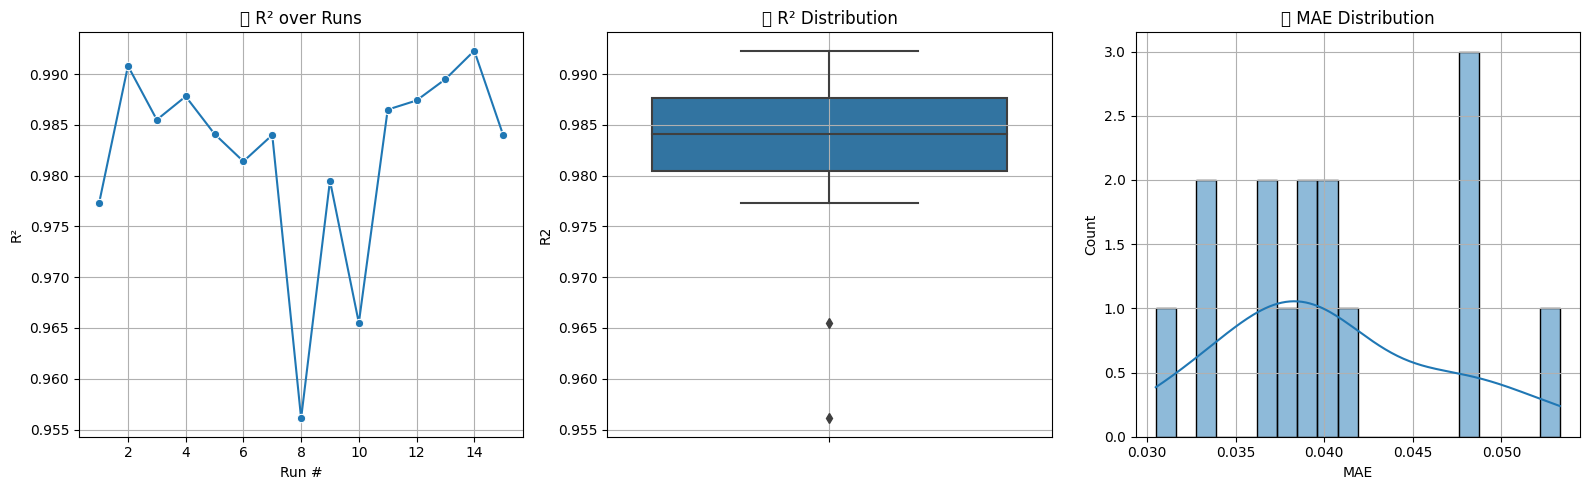

✅ Stability analysis complete:
{
    "R2_mean": 0.9821,
    "R2_std": 0.0097,
    "MAE_mean": 0.0404,
    "MAE_std": 0.0062,
    "MSE_mean": 0.004528,
    "MSE_std": 0.002553,
    "runs": 15
}
📁 Saved metrics: /kaggle/working/stability_working.json
🖼️  Saved plot: /kaggle/working/stability_plot_working.png


In [7]:
# 📁 src/tuning/analyze_stability.py

# 📌 Пути (адаптируй под свой путь к лог-файлу)

LOG_CSV_PATH = SAVE_ROOT / "stability_log.csv"
ARCH_LABEL = SAVE_ROOT.name  # используем имя папки как ярлык модели

# 📥 Загрузка результатов
df = pd.read_csv(LOG_CSV_PATH)

# ➕ Добавим колонку run по индексу
df["run"] = range(1, len(df) + 1)

# 📊 Подсчёт статистик стабильности
stability = {
    "R2_mean":  round(df["R2"].mean(), 4),
    "R2_std":   round(df["R2"].std(), 4),
    "MAE_mean": round(df["MAE"].mean(), 4),
    "MAE_std":  round(df["MAE"].std(), 4),
    "MSE_mean": round(df["MSE"].mean(), 6),
    "MSE_std":  round(df["MSE"].std(), 6),
    "runs": len(df)
}

# 💾 Сохраняем метрики
stability_path = SAVE_ROOT / f"stability_{ARCH_LABEL}.json"
with open(stability_path, "w") as f:
    json.dump(stability, f, indent=4)

# 📈 Визуализация
plt.figure(figsize=(16, 5))

# ➤ R² по прогонам
plt.subplot(1, 3, 1)
sns.lineplot(x="run", y="R2", data=df, marker="o", linewidth=1.5)
plt.title("📈 R² over Runs")
plt.xlabel("Run #")
plt.ylabel("R²")
plt.grid(True)

# ➤ Boxplot R²
plt.subplot(1, 3, 2)
sns.boxplot(y="R2", data=df)
plt.title("🎯 R² Distribution")
plt.grid(True)

# ➤ Гистограмма MAE
plt.subplot(1, 3, 3)
sns.histplot(df["MAE"], bins=20, kde=True)
plt.title("📉 MAE Distribution")
plt.xlabel("MAE")
plt.grid(True)

# 💾 Сохраняем график
fig_path = SAVE_ROOT / f"stability_plot_{ARCH_LABEL}.png"
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

# ✅ Вывод
print("✅ Stability analysis complete:")
print(json.dumps(stability, indent=4))
print(f"📁 Saved metrics: {stability_path}")
print(f"🖼️  Saved plot: {fig_path}")
